# Fun with Merging Clusters of Galaxies: An Exercise


View this in notebook viewer to get the javascript plugin effects. Paste the link in the webpage here: 

http://nbviewer.jupyter.org/github/amanshei/git_thesis/blob/master/Demo_galaxybin.ipynb

Question: Do cluster mergers trigger or quench star formation? How do we investigate this?

The system I am working with is unique (see sinister looking pic below, Fig 1A from Mansheim et. al 2017b). It is at redshift ~ 1.1, which is the high noon of structure formation. The age of the universe at this time/place was 5 Gyr, so about 8Glyr away/in past. The diameter of a cluster of galaxies is on order 1 Mpc (1pc is 3.26 ly ~6 trillion miles). These clusters will collide in 6 billion years, but their dark matter halos are already overlapping.

<p>
Learn from the past: Pick a system that is better equipped to answer the question.
</p>
<p>
Already Completed (often this gets revised or added last-minute):

* Acquire and reduce raw imaging and spectroscopic data
* Preliminary error analysis and modeling (redshifts, stellar models)
* Compile catalogs of raw data

<p>
Partially completed (mostly done in other notebooks until this point in the process):

* Merge and crossmatch initial catalogs and put into usable format

<p>
Next steps (potentially eternal feedback loop until we reach statistically significant results):

* Determine "features" that will help us answer our question (statistically and physically motivated)
* Figure out how to create features (write functions, learn new languages, algorithms, street smarts)
* Make more sophisticated measurements from observables
* Determine if we have a statistically significant result (statistics)
<p>

Exercise in binning galaxies in a way that makes sense for our hypothesis and is physically motivated.
<img src="demo_plots/VMC_overdensity_label_1.png" alt="Drawing" style="width: 500px;" />


In [88]:
#To Hide Cell Input
#from IPython.display import HTML
#HTML(addToggle())
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')


In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as py
import sys,os
import cluster_tools.profiles as profiles
import cluster_tools.CAT as CAT
import cluster_tools.tools as tools
import cluster_tools.cosmo as cosmos
import cluster_tools.Cluster_functs as t
import pickle
from scipy.stats import ks_2samp,kstest
#import scipy.integrate
import mpld3
from IPython.display import Image, display, HTML
from sklearn.utils import resample
import cluster_tools.scic_dist_functions as scic_dist
from mpld3 import plugins, utils
%pylab inline
#mpld3.enable_notebook()

Populating the interactive namespace from numpy and matplotlib


In [89]:

#Based on MPLD3 function by Jake VanderPlas
#For interactive plots and visualizations
class LinkedView(plugins.PluginBase):
    """A simple plugin showing how multiple axes can be linked"""

    JAVASCRIPT = """
    mpld3.register_plugin("linkedview", LinkedViewPlugin);
    LinkedViewPlugin.prototype = Object.create(mpld3.Plugin.prototype);
    LinkedViewPlugin.prototype.constructor = LinkedViewPlugin;
    LinkedViewPlugin.prototype.requiredProps = ["idpts", "idline", "data"];
    LinkedViewPlugin.prototype.defaultProps = {}
    function LinkedViewPlugin(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    LinkedViewPlugin.prototype.draw = function(){
      var pts = mpld3.get_element(this.props.idpts);
      var line = mpld3.get_element(this.props.idline);
      var data = this.props.data;

      function mouseover(d, i){
        line.data = data[i];
        line.elements().transition()
            .attr("d", line.datafunc(line.data))
            .style("stroke", this.style.fill);
      }
      pts.elements().on("mouseover", mouseover);
    };
    """

    def __init__(self, points, line, linedata):
        if isinstance(points, matplotlib.lines.Line2D):
            suffix = "pts"
        else:
            suffix = None

        self.dict_ = {"type": "linkedview",
                      "idpts": utils.get_id(points, suffix),
                      "idline": utils.get_id(line),
                      "data": linedata}

# Define some CSS to control our custom labels
css = """
table
{
  border-collapse: collapse;
}
th
{
  color: #E0E0E0 ;
  background-color: #663399;
}
td
{
  background-color: #CCCCFF;
}
table, th, td
{
  font-family:Arial, Helvetica, sans-serif;
  border: 1px solid black;
  text-align: left;
}
"""

In [90]:
#Cool but annoying: Cosmological constants, units and coordinate systems 
#Translate from projected sky coordinates (RA&Dec are not a linear grid and angular) 
#To a roughly 3D grid where the size corresponds to a distance like Mpc/lightyears
#Quantities depend on redshift (error prone) and cosmological model 
#(see other notebooks for details on calculations)
c = 3*10**5 #Units km/s
z=zC=1.105
rvirB=1.01207064831
rvirA=0.820350458861
#rvir = r200/1.14
r200A=rvirA*1.14
r200B=rvirB*1.14
zCB= 1.1024208 #mean redshift B
zCA= 1.1003972 #mean redshift A
#velocity dispersion
sigmaA, sigmaA_err=681.2,170.1 
sigmaB, sigmaB_err=840.4,244.0
#CENTROIDS measured using number density and MC resampling
raA,decA= 137.68400, 54.372387 #1mpc
raB,decB= 137.51280, 54.309944 #1mpc
M200A, M200B = 2.91546371993e+14,5.47446715836e+14 #5.47446715836, 2.91546371993

In [91]:
#Quick idea of environment
#Data wrangling (most of it was done in some other notebooks and using functions I wrote elsewhere)
#Advantages of Pandas: Multiindex for plotting and grouping, vectorized application of array operations
#Can basically do anything, or output to something that will (for example, to IDL spectra or imaging in DS9 or pyregion for plotting)
#Too much code to paste in here so see the other notebooks
#Optional example to add in future, show functions used to gather points in areas, how I wrote them in Pandas

In [92]:
#Just read in processed catalog for sake of time for demo (originally done in separate notebook)
filepath='/Users/alison/DLS/deimosspectracatalog/spectrastack/briansprog/preElgordo/Pre_elGordo_paper/cats/'
cat_all=pd.read_csv('/Users/alison/DLS/deimosspectracatalog/spectrastack/briansprog/preElgordo/Pre_elGordo_paper/cats/cat_all_PG.tab',sep='\t')
cat_gq=cat_all;

In [93]:
#Trim catalog of features will not use and remove areas with poor sampling, for speed
cat_gq=cat_all
cat_gq=pd.concat([cat_gq.loc[:,'id':'dec'], cat_gq.loc[:,'star':]],axis=1)
cat_gq.set_index(['id','z_group','q_group'],drop=False,inplace=True)
cat_gq=cat_gq[cat_gq.region_PG.notnull()]; #remove photometric objects outside slitmask area for accurate completeness statistics

In [94]:
#Creating columns that indicate the distance of each galaxy from the cluster center
#Convert sky coordinates to angular distance to MegaParsec using the median redshift
#Calculate the tidal force on each object using NFW dark matter halo parameters
#Some preliminary force calculations
cat_gq['LFC_RA']=cat_gq.ra
cat_gq['LFC_dec']=cat_gq.dec
raA,decA= 137.68400, 54.372387 #1mpc
raB,decB= 137.51280, 54.309944 #1mpc
f=lambda a,b: tools.angdist(a,b,raA,decA)*60*60
fMpc=lambda a,b: tools.angdist(a,b,raA,decA)*60*cosmos.ProjectedLength(z)
cat_gq['dA']=map(f,cat_gq.LFC_RA,cat_gq.LFC_DEC)
cat_gq['dAMpc']=map(fMpc,cat_gq.LFC_RA,cat_gq.LFC_DEC)
f=lambda a,b: tools.angdist(a,b,raB,decB)*60*60
fMpc=lambda a,b: tools.angdist(a,b,raB,decB)*60*cosmos.ProjectedLength(z)
cat_gq['dB']=map(f,cat_gq.LFC_RA,cat_gq.LFC_DEC)
cat_gq['dBMpc']=map(fMpc,cat_gq.LFC_RA,cat_gq.LFC_DEC)
del_cA, rsA, r200A_will, csA, rhosA = profiles.nfwparam_extended(M200A/1e14,z,h_scale=0.7,Om=0.3,Ol=0.70,Or=0.0)
del_cB, rsB, r200B_will, csB, rhosB = profiles.nfwparam_extended(M200B/1e14,z,h_scale=0.7,Om=0.3,Ol=0.70,Or=0.0)
#print del_cA, rsA, r200A_will, csA, rhosA #rho M_sun/Mpc^3, r200 Mpc
#print del_cB, rsB, r200B_will, csB, rhosB
R=10*1e-3 #10kpc in Mpc (~0.01 Mpc)radius galaxy reasonable, ellipticals range 0.3-100+kpc (eventually half light radius of each)
m=1e12 #units Msun. Milky way is .8-1.5e12. ellipticals can be e7-e13
G = 6.673*10**-11 # m**3/kg/s**2, or  N*m**2 / kg**2
c = 3e8 #speed of light m/s
kginMsun = 1.98892*10**30 # kg in a solar mass
minMpc = 3.08568025*10**22 # m in a Megaparsec            
r2d = 180/np.pi # radians to degrees conversion factor
FtoNewtons = kginMsun**2 / minMpc**2
cat_gq['M_A']=pd.Series(np.repeat(np.array(np.nan),len(cat_gq)), index=cat_gq.index)
cat_gq['M_B']=pd.Series(np.repeat(np.array(np.nan),len(cat_gq)), index=cat_gq.index)
cat_gq['F_tAB']=pd.Series(np.repeat(np.array(np.nan),len(cat_gq)), index=cat_gq.index)
rhos,rs=rhosA,rsA
func_Menc= lambda r: 4.*np.pi *rhos*rs**3*( np.log( (rs+r)/rs ) - r/(r+rs) ) #enclosed mass at distance r from cluster core of A or B
func_Ft=lambda r,M: G*M*m*( 1/r**2. - 1/(r+R)**2. )*FtoNewtons #Force in galaxy radius R a distance r from clust
cat_gq['M_A']=map(func_Menc, cat_gq['dAMpc']) #Msun
cat_gq['F_A']=map(func_Ft, cat_gq['dAMpc'], cat_gq['M_A'])
#diff force from cluster B on galaxy radius R at distance from cluster core dBMpc
rhos,rs=rhosB,rsB
func_Menc= lambda r: 4.*np.pi *rhos*rs**3*( np.log( (rs+r)/rs ) - r/(r+rs) ) #enclosed mass at distance r from cluster core of A or B
func_Ft=lambda r,M: G*M*m*( 1/r**2. - 1/(r+R)**2. )*FtoNewtons #Force in galaxy radius R a distance r from clust
cat_gq['M_B']=map(func_Menc, cat_gq['dBMpc'])
cat_gq['F_B']=map(func_Ft, cat_gq['dBMpc'],cat_gq['M_B'])
func_Ftot=lambda a,b: a+b
cat_gq['F_tAB']=map(func_Ftot, cat_gq['F_A'],cat_gq['F_B']);
#print 'F_tAB, F_tA, F_tB',cat_gq['F_tAB'][cat_gq.q_group=='high'].mean(),cat_gq['F_A'][cat_gq.q_group=='high'].mean(),cat_gq['F_B'][cat_gq.q_group=='high'].mean()
#print cat_gq['F_tAB'][cat_gq.q_group=='high'].describe()#, cat_gq['M_A'][cat_gq.q_group=='high'].describe()

Galaxies within 2 Virial Radii for A and B 28 35


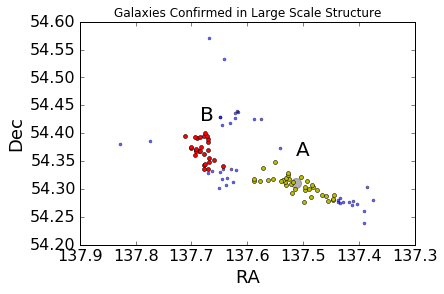

In [95]:
#Now that we have some useful parameters, let's explore the system
#Binning is also a question of clustering, although less of an issue than with our first paper
#We decided to use virial radii because they had not yet been disturbed (instead of number density)
py.text(raA,decA+.05, 'B',fontsize=20)
py.scatter(raB,decB, marker='o', c='k', s=100, alpha=0.3)
py.text(raB,decB+.05, 'A',fontsize=20)

py.plot(cat_gq.xs(['cz','high'],level=['z_group','q_group']).LFC_RA, cat_gq.xs(['cz','high'],level=['z_group','q_group']).LFC_DEC,'bo',ms=3,alpha=.6)
py.plot(cat_gq[cat_gq.dAMpc<2*rvirA].xs(['cz','high'],level=['z_group','q_group']).LFC_RA, cat_gq[cat_gq.dAMpc<2*rvirA].xs(['cz','high'],level=['z_group','q_group']).LFC_DEC,'ro',ms=4)
py.plot(cat_gq[cat_gq.dBMpc<2*rvirB].xs(['cz','high'],level=['z_group','q_group']).LFC_RA, cat_gq[cat_gq.dBMpc<2*rvirB].xs(['cz','high'],level=['z_group','q_group']).LFC_DEC,'yo',ms=4)
print 'Galaxies within 2 Virial Radii for A and B',len(cat_gq[cat_gq.dAMpc<2*rvirA].xs(['cz','high'],level=['z_group','q_group']).LFC_RA),len(cat_gq[cat_gq.dBMpc<2*rvirB].xs(['cz','high'],level=['z_group','q_group']).LFC_RA)
py.gca().invert_xaxis()
py.title('Galaxies Confirmed in Large Scale Structure')
py.xlabel('RA',fontsize=18)
py.ylabel('Dec',fontsize=18)
py.tick_params(axis='both', which='major', labelsize=16)
py.ticklabel_format(useOffset=False)

How do we prove our hypothesis? We need to compare the areas near the front of the merger to the areas in the back. We do this by first rotating the entire data set so that the merger axis is along a new X-axis. It is then straightforward to make linear bins. After much work trying to project-rotate-deproject points, I found an approximation and a simple rotation matric around 30 degrees where RA ~ RA*cos(54.33) was adequate. In astronomy we do a lot of line fitting and usually subtract out the slope, but nonlinear coordinate grids add an extra element of fun.
<p>
I also continued examining the membership as I varied the cluster boundary, which must be physically significant but also yield an adequate and number of galaxies to minimize noise and make a comparison when we add galaxy spectra. If the noise is too great, we cannot prove a significant difference in star formation between the bins. In addition, while the clusters have not yet merged and have smooth X-ray contours, it is clear by the galaxy distribution the clusters are in a filamentary structure. Irregularities must be taken into account in the end.

Galaxies within 1.5 Rvir for A and B 25 27
Galaxies within 0.5 Rvir for A and B 8 9
Galaxies within Rproj>0.5 & <=1.5 Rvir annulus for A and B 17 18


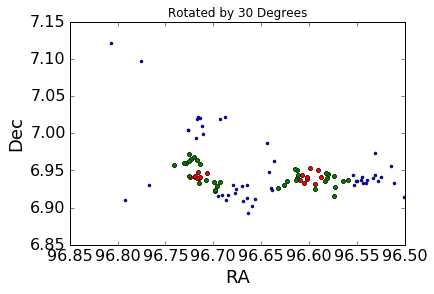

In [96]:
cat_gq['rax']=cat_gq.LFC_RA*np.cos(np.deg2rad(54.33))
theta=30
theta=np.deg2rad(theta)
cat_gq['xprime'] = np.cos(theta)*cat_gq.rax +np.sin(theta)*cat_gq.LFC_DEC
cat_gq['yprime'] = -np.sin(theta)*cat_gq.rax+np.cos(theta)*cat_gq.LFC_DEC
py.plot(cat_gq.xs(['cz','high'],level=['z_group','q_group']).xprime,cat_gq.xs(['cz','high'],level=['z_group','q_group']).yprime,'bo',ms=3)

py.plot(cat_gq[cat_gq.dAMpc<=1.5*rvirA].xs(['cz','high'],level=['z_group','q_group']).xprime, cat_gq[cat_gq.dAMpc<=1.5*rvirA].xs(['cz','high'],level=['z_group','q_group']).yprime,'yo',ms=4)
py.plot(cat_gq[cat_gq.dBMpc<=1.5*rvirB].xs(['cz','high'],level=['z_group','q_group']).xprime, cat_gq[cat_gq.dBMpc<=1.5*rvirB].xs(['cz','high'],level=['z_group','q_group']).yprime,'yo',ms=4)
print 'Galaxies within 1.5 Rvir for A and B',len(cat_gq[cat_gq.dAMpc<=1.5*rvirA].xs(['cz','high'],level=['z_group','q_group']).xprime),len(cat_gq[cat_gq.dBMpc<=1.5*rvirB].xs(['cz','high'],level=['z_group','q_group']).yprime)

py.plot(cat_gq[cat_gq.dAMpc<=0.5*rvirA].xs(['cz','high'],level=['z_group','q_group']).xprime, cat_gq[cat_gq.dAMpc<=0.5*rvirA].xs(['cz','high'],level=['z_group','q_group']).yprime,'ro',ms=4)
py.plot(cat_gq[cat_gq.dBMpc<=0.5*rvirB].xs(['cz','high'],level=['z_group','q_group']).xprime, cat_gq[cat_gq.dBMpc<=0.5*rvirB].xs(['cz','high'],level=['z_group','q_group']).yprime,'ro',ms=4)
print 'Galaxies within 0.5 Rvir for A and B',len(cat_gq[cat_gq.dAMpc<=0.5*rvirA].xs(['cz','high'],level=['z_group','q_group']).xprime),len(cat_gq[cat_gq.dBMpc<=0.5*rvirB].xs(['cz','high'],level=['z_group','q_group']).yprime)

py.plot(cat_gq[(cat_gq.dAMpc<=1.5*rvirA)&(cat_gq.dAMpc>0.5*rvirA)].xs(['cz','high'],level=['z_group','q_group']).xprime, cat_gq[(cat_gq.dAMpc<=1.5*rvirA)&(cat_gq.dAMpc>0.5*rvirA)].xs(['cz','high'],level=['z_group','q_group']).yprime,'go',ms=4)
py.plot(cat_gq[(cat_gq.dBMpc<=1.5*rvirB)&(cat_gq.dBMpc>0.5*rvirB)].xs(['cz','high'],level=['z_group','q_group']).xprime, cat_gq[(cat_gq.dBMpc<=1.5*rvirB)&(cat_gq.dBMpc>0.5*rvirB)].xs(['cz','high'],level=['z_group','q_group']).yprime,'go',ms=4)
print 'Galaxies within Rproj>0.5 & <=1.5 Rvir annulus for A and B',len(cat_gq[(cat_gq.dAMpc<=1.5*rvirA)&(cat_gq.dAMpc>0.5*rvirA)].xs(['cz','high'],level=['z_group','q_group']).xprime),len(cat_gq[(cat_gq.dBMpc<=1.5*rvirB)&(cat_gq.dBMpc>0.5*rvirB)].xs(['cz','high'],level=['z_group','q_group']).yprime)
py.title('Rotated by 30 Degrees')
py.gca().invert_xaxis()
py.xlabel('RA',fontsize=18)
py.ylabel('Dec',fontsize=18)
py.tick_params(axis='both', which='major', labelsize=16)
py.ticklabel_format(useOffset=False)


In order to tie bin size to physically significant units (Virial Radii in Mega parsec) I needed to come up with way to translate distances to points in the new coordinate system. It was also clear I needed to set up a pipeline so we could systematically vary bins and do a quick data analysis to view the relative levels of star formation.

In [97]:
#TRANSLATE SINGLE POINT
raA,decA= 137.68400, 54.372387 #1mpc
raB,decB= 137.51280, 54.309944 #1mpc
#print tools.angdist(raA,decA,raB,decB)*60 ,'arcmin angular distance'
#print tools.angdist(raA,decA,raB,decB)*60*60 ,'arcsec angular distance'
#print tools.angdist(raA,decA,raB,decB)*60*cosmos.ProjectedLength(z) ,'Mpc'
#print tools.angdist(raA,decA,raB,decB)*60 /(tools.angdist(raA,decA,raB,decB)*60*cosmos.ProjectedLength(z)),'arcmin/Mpc'
#print 12*tools.angdist(raA,decA,raB,decB)*60 /(tools.angdist(raA,decA,raB,decB)*60*cosmos.ProjectedLength(z)),'8Mpc*arcmin/Mpc'
ra, dec = raA, decA
rax=ra*np.cos(np.deg2rad(54.33))
rot=np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
x= np.array([ [rax],[dec] ])
np.dot(rot,x)
#print 'New RA',np.dot(rot,x)[0],'New DEC',np.dot(rot,x)[1]

#TRANSLATE MANY POINTS, 
#find new distance scale and corresponding values for key lengths in new coordinate system
bins=[raA,raB]
y=[decA,decB]
ra_rots=[]
dec_rots=[] #nI think I want tuples if I can plot them...eventually
for ra,dec in zip(bins,y):
#    for dec in y:
        rax=ra*np.cos(np.deg2rad(54.33))
        x= np.array([ [rax],[dec] ])
        dec_rot=np.dot(rot ,x)[1]
        ra_rot=np.dot(rot ,x)[0]
        ra_rots.append(ra_rot[0])
        dec_rots.append(dec_rot[0])
ra_rotA, ra_rotB= ra_rots[0],ra_rots[1]
dec_rotA, dec_rotB= dec_rots[0],dec_rots[1]
#print zip(np.array(ra_rots),np.array(dec_rots))

#DISTANCE SCALE (can be applied to y if want to select area/height in Mpc)
#This one is based on centroids but the scale shouldn't change
dx=np.array(ra_rots)[0]-np.array(ra_rots)[1]
#print dx
#print tools.angdist(raA,decA,raB,decB)*60*60 #ARCSEC
#print tools.angdist(raA,decA,raB,decB)*60*cosmos.ProjectedLength(z) #MPC
print 'Mpc/Degree', 60*cosmos.ProjectedLength(z)
#tools.angdist(raA,decA,raB,decB)/tools.angdist(raA,decA,raB,decB)*60*cosmos.ProjectedLength(z)
print 'conversion scale for dx/arcsec',dx/(tools.angdist(raA,decA,raB,decB)*60*60)
print 'conversion scale for dx/Mpc',dx/(tools.angdist(raA,decA,raB,decB)*60*cosmos.ProjectedLength(z))
print 'conversion scale for arcsec/dx',(tools.angdist(raA,decA,raB,decB)*60*60)/dx
print 'conversion scale for Mpc/dx',(tools.angdist(raA,decA,raB,decB)*60*cosmos.ProjectedLength(z))/dx
print 'So 4.6Mpc is 4.6Mpc*(dx/Mpc->dx)',4.6*dx/(tools.angdist(raA,decA,raB,decB)*60*cosmos.ProjectedLength(z))
print 'So 1.01207064831 Mpc is X Mpc*(dx/Mpc->dx)',1.01207064831*dx/(tools.angdist(raA,decA,raB,decB)*60*cosmos.ProjectedLength(z))
print 'So 0.820350458861 Mpc is X Mpc*(dx/Mpc->dx)',0.820350458861*dx/(tools.angdist(raA,decA,raB,decB)*60*cosmos.ProjectedLength(z))
#Now do this for constants
dx2Mpc=(tools.angdist(raA,decA,raB,decB)*60*cosmos.ProjectedLength(z))/dx
dx2arcsec=(tools.angdist(raA,decA,raB,decB)*60*60)/dx
Mpc2dx=dx/(tools.angdist(raA,decA,raB,decB)*60*cosmos.ProjectedLength(z))
arcsec2dx=dx/(tools.angdist(raA,decA,raB,decB)*60*60)
RvirA_rot=rvirA*Mpc2dx
RvirB_rot=rvirB*Mpc2dx
R200A_rot=r200A*Mpc2dx
R200B_rot=r200B*Mpc2dx

Mpc/Degree 39.2654294914
conversion scale for dx/arcsec 0.000277658463615
conversion scale for dx/Mpc 0.0254567562856
conversion scale for arcsec/dx 3601.54697603
conversion scale for Mpc/dx 39.2823024576
So 4.6Mpc is 4.6Mpc*(dx/Mpc->dx) 0.117101078914
So 1.01207064831 Mpc is X Mpc*(dx/Mpc->dx) 0.0257640358379
So 0.820350458861 Mpc is X Mpc*(dx/Mpc->dx) 0.0208834617


We tried several iterations where I would then plot the galaxy magnitudes on a Color-Magnitude Diagram to get a view of ensemble properties of populations in each bin then output catalogs and create composites and measure line strengths (can see in extended notebooks on my github). Here are a few plots from these iterations:

<img src="demo_plots/Rvir_radialg2radec_unrot.png" alt="Drawing" style="width: 500px;" />
<img src="demo_plots/new_bin_radialg2.png" alt="Drawing" style="width: 500px;" />
<img src="demo_plots/Binned_radec_unrot.png" alt="Drawing" style="width: 500px;" />


Looking at rotated and unrotated versions, we settled on a definition that was **physically motivated**. Dark matter halos are spherical under currently accepted theories, so the effects will be strongest in an irregularly shaped region between the clusters. Similarly, if we are to remove the cluster cores because they contaminate the measurements, based on symmetry we should define our bins spherically so we do not contaminate bins 4 and 10 with galaxies at different radii from the center. It is well accepted that galaxy type varies with cluster radius- galaxies in the center are on average red and dead, galaxies on the outskirts on average still have star formation activity.
<p>
I chose an interactive version of this plot so we could see live both useful properties and which objects corresponded to the object ID's in other types of diagrams which plotted other properties. For example, if there was a very bright object on the boundary between two binning methods we could anticipate this biasing the star formation rates (mplD3 is a few years old, now this seems pretty standard in online plots).

Galaxies within Rproj>0.5 & <=1.5 Rvir annulus for A and B 17 18
Galaxies within 4.0 Mpc Rvir annulus for A and B 19
Galaxies within 3.5 Mpc Rvir annulus for A and B 10


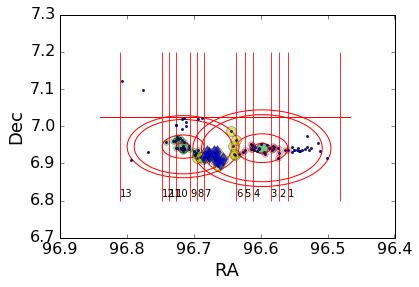

In [98]:
#I know I will have to repeat this many time, so it must be easy to manipulate and display
#Binning: How do we make linear bins and include data that will give us enough signal
#Also Eliminate areas with poor telescope coverage (see point in poly)
#VERSION COPIED CEL WITH INLINE TO VIEW
#SECOND SET BINS
#DEFINE NEW BINS
mpld3.enable_notebook()
#%pylab inline
binsAleft=[ra_rotA,ra_rotA+RvirA_rot/2,ra_rotA+RvirA_rot,ra_rotA+RvirA_rot*4]
binsBleft=[ra_rotB,ra_rotB+RvirB_rot,ra_rotB+RvirB_rot*1.5,ra_rotB+RvirB_rot*2]
binsAright=[ra_rotA-RvirA_rot,ra_rotA-RvirA_rot*1.5,ra_rotA-RvirA_rot*2]    
binsBright=[ra_rotB-RvirB_rot,ra_rotB-RvirB_rot*.5,ra_rotB-RvirB_rot*4]    
binsA=binsAleft+binsAright
binsB=binsBleft+binsBright
#bins=(np.array(bins)-RvirA_rot/4) #shifts bins to Right by RvirA_rot/2
#bins=(np.array(bins)+RvirA_rot/4) #shifts bins to LEFT by RvirA_rot/2
binsA=(np.array(binsA)+RvirA_rot/2).tolist() #shifts bins to LEFT by RvirA_rot/2
binsB=(np.array(binsB)-RvirB_rot/2).tolist() #shifts bins to RIGHT by RvirB_rot/2
bins=binsA+binsB
bins.sort() #should make this low to high, originally low to high
binwMpc=[(round(abs(bins[i]-bins[i+1])*dx2Mpc,2),i+1) for i in arange(len(bins)-1)]#print '{:.2f}'.format(zip(*binwMpc)[0])
#print zip(*binwMpc)[0]
#print zip(*binwMpc)[1]
cat_gq.set_index(['z_group','q_group'],drop=False,inplace=True)
fig, ax = py.subplots()
#py.rcParams['figure.figsize'] = (20, 16)
py.rcParams['figure.figsize'] = (10, 6)
py.plot(cat_gq.xs(['cz','high'],level=['z_group','q_group']).xprime, cat_gq.xs(['cz','high'],level=['z_group','q_group']).yprime,'bo',ms=2,alpha=0.8)
py.plot(cat_gq[(cat_gq.dAMpc<=1.5*rvirA)&(cat_gq.dAMpc>0.5*rvirA)].xs(['cz','high'],level=['z_group','q_group']).xprime, cat_gq[(cat_gq.dAMpc<=1.5*rvirA)&(cat_gq.dAMpc>0.5*rvirA)].xs(['cz','high'],level=['z_group','q_group']).yprime,'go',ms=6,alpha=0.3)
py.plot(cat_gq[(cat_gq.dBMpc<=1.5*rvirB)&(cat_gq.dBMpc>0.5*rvirB)].xs(['cz','high'],level=['z_group','q_group']).xprime, cat_gq[(cat_gq.dBMpc<=1.5*rvirB)&(cat_gq.dBMpc>0.5*rvirB)].xs(['cz','high'],level=['z_group','q_group']).yprime,'ro',ms=6,alpha=0.3)
print 'Galaxies within Rproj>0.5 & <=1.5 Rvir annulus for A and B',len(cat_gq[(cat_gq.dAMpc<=1.5*rvirA)&(cat_gq.dAMpc>0.5*rvirA)].xs(['cz','high'],level=['z_group','q_group']).xprime),len(cat_gq[(cat_gq.dBMpc<=1.5*rvirB)&(cat_gq.dBMpc>0.5*rvirB)].xs(['cz','high'],level=['z_group','q_group']).yprime) 
py.plot(cat_gq[( (cat_gq.dBMpc<=4.0*rvirB)&(cat_gq.dBMpc>1.5*rvirB) & (cat_gq.dAMpc<=4.0*rvirA )&(cat_gq.dAMpc>1.5*rvirA ) )].xs(['cz','high'],level=['z_group','q_group']).xprime,cat_gq[( (cat_gq.dBMpc<=4*rvirB)&(cat_gq.dBMpc>1.5*rvirB) & (cat_gq.dAMpc<=4.0*rvirA )&(cat_gq.dAMpc>1.5*rvirA ) )].xs(['cz','high'],level=['z_group','q_group']).yprime,'yo',ms=10,alpha=0.5 )
print 'Galaxies within 4.0 Mpc Rvir annulus for A and B',len(cat_gq[( (cat_gq.dBMpc<=4.0*rvirB)&(cat_gq.dBMpc>1.5*rvirB) & (cat_gq.dAMpc<=4.0*rvirA )&(cat_gq.dAMpc>1.5*rvirA ) )].xs(['cz','high'],level=['z_group','q_group']) )
RvA=py.Circle((ra_rotA,dec_rotA),4.0*RvirA_rot , color='r',fill=False) #B
RvB=py.Circle((ra_rotB,dec_rotB),4.0*RvirB_rot, color='r',fill=False) #A
py.gca().add_artist(RvA)
py.gca().add_artist(RvB)
py.plot(cat_gq[( (cat_gq.dBMpc<=3.5*rvirB)&(cat_gq.dBMpc>1.5*rvirB) & (cat_gq.dAMpc<=3.5*rvirA )&(cat_gq.dAMpc>1.5*rvirA ) )].xs(['cz','high'],level=['z_group','q_group']).xprime,cat_gq[( (cat_gq.dBMpc<=3.5*rvirB)&(cat_gq.dBMpc>1.5*rvirB) & (cat_gq.dAMpc<=3.5*rvirA )&(cat_gq.dAMpc>1.5*rvirA ) )].xs(['cz','high'],level=['z_group','q_group']).yprime,'bd',ms=10,alpha=0.7 )
print 'Galaxies within 3.5 Mpc Rvir annulus for A and B',len(cat_gq[( (cat_gq.dBMpc<=3.5*rvirB)&(cat_gq.dBMpc>1.5*rvirB) & (cat_gq.dAMpc<=3.5*rvirA )&(cat_gq.dAMpc>1.5*rvirA ) )].xs(['cz','high'],level=['z_group','q_group']) )
py.axhline(y=7.025, xmin=cat_gq.xprime.max(), xmax=cat_gq.xprime.min(), linewidth=10, color = 'r')
py.axhline(y=7.025, xmin=cat_gq.xprime.min(), xmax=cat_gq.xprime.max(), linewidth=10, color = 'r')
RvA=py.Circle((ra_rotA,dec_rotA),3.5*RvirA_rot , color='r',fill=False) #B
RvB=py.Circle((ra_rotB,dec_rotB),3.5*RvirB_rot, color='r',fill=False) #A
py.gca().add_artist(RvA)
py.gca().add_artist(RvB)
RvA=py.Circle((ra_rotA,dec_rotA),1.5*RvirA_rot , color='r',fill=False) #B
RvB=py.Circle((ra_rotB,dec_rotB),1.5*RvirB_rot, color='r',fill=False) #A
py.gca().add_artist(RvA)
py.gca().add_artist(RvB)
RvA=py.Circle((ra_rotA,dec_rotA),0.5*RvirA_rot , color='r',fill=False) #B
RvB=py.Circle((ra_rotB,dec_rotB),0.5*RvirB_rot, color='r',fill=False) #A
py.gca().add_artist(RvA)
py.gca().add_artist(RvB)
#py.plot(cat_gq.xs(['cz','high'],level=['z_group','q_group']).xprime,cat_gq.xs(['cz','high'],level=['z_group','q_group']).yprime,'bo',ms=3)
ymin, ymax =6.8000000000000007, 7.2000000000000011
py.scatter( ra_rotA,dec_rotA, marker='o', c='g', s=130, alpha=0.5)
py.scatter(  ra_rotB,dec_rotB, marker='o', c='g', s=130, alpha=0.5)
for i,bin in enumerate(bins):
    py.vlines(bin, ymin, ymax, linestyle='solid', linewidth=0.8, color='r' )
    if (i!=0):
        py.text(bin,ymin+0.01,str(i),color='k',fontsize='10')
py.gca().invert_xaxis()
py.xlabel('RA',fontsize=18)
py.ylabel('Dec',fontsize=18)
py.tick_params(axis='both', which='major', labelsize=16)
py.ticklabel_format(useOffset=False)
yplim=[7.025,7.025]
xplim=[ 96.4670770621,96.8396815522]
py.plot(xplim,yplim,'r-')
#folder='Rvir_radialg4'
#targetdir='/Users/alison/DLS/deimosspectracatalog/spectrastack/briansprog/preElgordo/Pre_elGordo_paper/cats/cats_groupby/'+folder+'/'
#py.savefig(targetdir+folder+'radec_unrot')
ax.plot(cat_gq.xs(['cz','high'],level=['z_group','q_group']).xprime, cat_gq.xs(['cz','high'],level=['z_group','q_group']).yprime,'bo',ms=2,alpha=0.8)
points=ax.plot(cat_gq.xs(['cz','high'],level=['z_group','q_group']).xprime, cat_gq.xs(['cz','high'],level=['z_group','q_group']).yprime,'wo',mfc='None',ms=5,alpha=0.01)
labelsp = []
for i in range(len(cat_gq.xs(['cz','high'],level=['z_group','q_group']))):
    labelp=cat_gq.xs(['cz','high'],level=['z_group','q_group']).ix[[i], ['Z','ra','dec','z_group','z_group_pz','q_group']].T
    labelp.columns = ['{0}'.format(cat_gq.xs(['cz','high'],level=['z_group','q_group']).id_phot[i])]
    labelsp.append(str(labelp.to_html()))    
tooltip = plugins.PointHTMLTooltip(points[0], labelsp,voffset=10, hoffset=10, css=css)
mpld3.plugins.connect(fig, tooltip)
#Only uncomment if you have the mpld3 enable notebook uncommented
#py.rcParams['figure.figsize'] = (20, 16)
#py.savefig('Binned_radec_unrot')

Final bins. Weird shape is due to intersection with mask boundary that dictates where we targeted and acquired spectra for a satisfactory number of galaxies. I did this irregular cut and used a series of functions I wrote for the previous paper that makes it easy to create arbitrarily shaped contours using imaging software, then visually select the contours you want, then determine which obsjects in a catalog fall inside which contours. These are on my git in git_random from a few years ago, and the ones for this mask also part of Cluster_functs file of useful pandas functions for observational astronomers I wrote and compiled (used in the New_0910 notebook for data wrangling).

Note, if you check outthe code in the cell below, I leverage Pandas Multiindexing to group and name objects in each bin, which is useful for the rest of the analysis when doing calculations, outputting catalogs to interfact with other programs and visualizing and plotting the data.

slice
core A           156
core B           188
infall A        1011
infall B        1360
merger back     7725
merger front    2049
unassigned      7804
dtype: int64


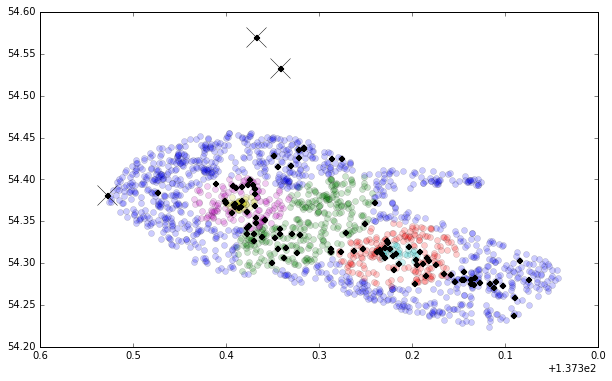

In [99]:
core_condA, core_condB=(cat_gq.dAMpc<0.5*rvirA),(cat_gq.dBMpc<0.5*rvirB)
annulus_condA,annulus_condB=((cat_gq.dAMpc<=1.5*rvirA)&(cat_gq.dAMpc>0.5*rvirA)),(cat_gq.dBMpc<=1.5*rvirB)&(cat_gq.dBMpc>0.5*rvirB)
cat_gq.reset_index(inplace=True,drop=True)
grouped_xbins_i = cat_gq.groupby(pd.cut(cat_gq.xprime,bins,labels=[str(i+1) for i in arange(len(bins)-1)]))
cat_gq['slice_i']=pd.Series(np.repeat(np.array('no slice'),len(cat_gq)), index=cat_gq.index)
for a in [str(i+1) for i in arange(len(bins)-1)]:
    cat_gq['slice_i'].loc[grouped_xbins_i.get_group(a).index]=a
#print cat_gq.groupby('slice_i').size()
labels=['merger back','infall B','core B','merger front','infall A','core A'] #conpare 1+13 to see how diff they are
bins3=['1','2','3','4','5','6'] #This is to assign new bin numbers for coadd program if don't want to use string names
bins2=[['1','13'],['2','3','4','5','6'],['2','3','4','5','6'],['7'],['8','9','10','11','12'],['8','9','10','11','12'] ]
colors=['bo','ro','co','go','mo','yo']
cat_gq['slice']=pd.Series(np.repeat(np.array('unassigned'),len(cat_gq)), index=cat_gq.index)
cat_gq['slice_i2']=pd.Series(np.repeat(np.array('7'),len(cat_gq)), index=cat_gq.index) #Could change this back to string
cat_gq['slice_i34']=pd.Series(np.repeat(np.array('non'),len(cat_gq)), index=cat_gq.index) #Could change this back to string
dic=dict(zip(labels, bins3)) #probably easier just to zip all when iterating because dict only has one def
'''
#Bin by get_group not working unless using id while separating out -1 spectra which won't go into completeness calc
#But also won't assign to using loc with more than one condition unless maybe do mapping??? Took easy 
#for bini,bin,label in zip(bins3,bins2,labels):
#    for j in bin:
        
        #print j, label
        if j in ['1','13']:
            print 'assigning',j,label, bini
            cat_gq['slice'].loc[grouped_xbins_i.get_group(j).index].count()
            cat_gq.loc[grouped_xbins_i.get_group(j).index,'slice']=label
            cat_gq.loc[grouped_xbins_i.get_group(j).index,'slice_i2']=dic[label]
      
        
        if j in ['7']:
            print 'assigning',j,label,bini
            cat_gq['slice'].loc[grouped_xbins_i.get_group(j).index].count()
            cat_gq.loc[grouped_xbins_i.get_group(j).index,'slice']=label
            cat_gq.loc[grouped_xbins_i.get_group(j).index,'slice_i2']=dic[label]
            #cat_gq['slice'].loc[grouped_xbins_i.get_group(j).index]=label

            #Could do a height cut here for slices or everywhere
'''
'''
        
        if j in ['2','3','4','5','6']:
            #print j,label
            #apply mask to A
                #print 'done',j,label
            if (label=='infall B'):
                print j,label
                #print cat_gq['slice'].loc[annulus_condA].loc[grouped_xbins_i.get_group(j).index].count()
                print cat_gq['slice'].loc[grouped_xbins_i.get_group(j).index].count()
                #print cat_gq['slice'].loc[annulus_condB].count()
                #cat_gq['slice'].loc[annulus_condA]=label
                #print cat_gq['slice'].loc[grouped_xbins_i.get_group(j).index].loc[annulus_condA].count()
                print cat_gq['slice'].loc[grouped_xbins_i.get_group(j).index][annulus_condB].count()
                print cat_gq.loc[cat_gq[annulus_condB].index.isin(grouped_xbins_i.get_group(j).index),['slice']].count()
                cat_gq.loc[cat_gq[annulus_condB].index.isin(grouped_xbins_i.get_group(j).index),['slice']]=label
                #cat_gq.dBMpc<0.5*rvirB
                #cat_gq['slice'].loc[grouped_xbins_i.get_group(j).index]=cat_gq.dBMpc.loc[grouped_xbins_i.get_group(j).index].apply(lambda x: str(label) if (x<0.5*rvirB) else str('core B'))
                #print 'done',j,label
            
            if (label=='core B'):
                print j,label
                #print cat_gq['slice'].loc[grouped_xbins_i.get_group(j).index]=label
                #cat_gq['slice'].loc[grouped_xbins_i.get_group(j).index].loc[core_condA]=label
                #cat_gq['slice'].loc[grouped_xbins_i.get_group(j).index]=label
                #cat_gq['slice'].loc[grouped_xbins_i.get_group(j).index][core_condB]=label
                #cat_gq['slice'].loc[grouped_xbins_i.get_group(j).index]=cat_gq.dBMpc.loc[grouped_xbins_i.get_group(j).index].apply(lambda x: str(label) if ((x<=1.5*rvirB)&(x>0.5*rvirB)) else 'False')
                #cat_gq['slice'].loc[annulus_condB]=label
            #else:
            #    continue
        elif j in ['8','9','10','11','12']:
            #apply mask to B
            if (label=='infall A'):
                cat_gq['slice'].loc[grouped_xbins_i.get_group(j).index]=label
#                cat_gq['slice'].loc[grouped_xbins_i.get_group(j).index]=label
            if (label=='core A'):
                cat_gq['slice'].loc[grouped_xbins_i.get_group(j).index]=label
                print j,label
'''
cat_gq.loc[( (cat_gq.dBMpc<=3.5*rvirB)&(cat_gq.dBMpc>1.5*rvirB) & (cat_gq.dAMpc<=3.5*rvirA)&(cat_gq.dAMpc>1.5*rvirA) ),'slice_i34']='merger front 3p5'
#NEW definition of MERGER BACK, removed above linear string assignment for slice
#Objects within 4*Rvir but greater than 1.5*Rvir (annulus same as merger front, but NOT in merger front)
cat_gq.loc[( ((cat_gq.dBMpc<=4.0*rvirB)&(cat_gq.dBMpc>1.5*rvirB)) | ((cat_gq.dAMpc<=4.0*rvirA)&(cat_gq.dAMpc>1.5*rvirA)) ),'slice']='merger back'
cat_gq.loc[( ((cat_gq.dBMpc<=4.0*rvirB)&(cat_gq.dBMpc>1.5*rvirB)) | ((cat_gq.dAMpc<=4.0*rvirA)&(cat_gq.dAMpc>1.5*rvirA)) ),'slice_i2']=dic['merger back']
cat_gq.loc[( (cat_gq.dBMpc<=4.0*rvirB)&(cat_gq.dBMpc>1.5*rvirB) & (cat_gq.dAMpc<=4.0*rvirA)&(cat_gq.dAMpc>1.5*rvirA) ),'slice']='merger front'
cat_gq.loc[( (cat_gq.dAMpc<=4.0*rvirA)&(cat_gq.dAMpc>1.5*rvirA) & (cat_gq.dBMpc<=4.0*rvirB)&(cat_gq.dBMpc>1.5*rvirB) ),'slice_i2']=dic['merger front']
cat_gq.loc[(~( (cat_gq.dBMpc<=3.5*rvirB)&(cat_gq.dBMpc>1.5*rvirB) & (cat_gq.dAMpc<=3.5*rvirA)&(cat_gq.dAMpc>1.5*rvirA) ) ) & ( (cat_gq.dBMpc<=4.0*rvirB)&(cat_gq.dBMpc>1.5*rvirB) & (cat_gq.dAMpc<=4.0*rvirA)&(cat_gq.dAMpc>1.5*rvirA) ),'slice_i34']='merger front 3_4'
#cat_gq.loc[(~( (cat_gq.dAMpc<=3.5*rvirA)&(cat_gq.dAMpc>1.5*rvirA) & (cat_gq.dBMpc<=3.5*rvirB)&(cat_gq.dBMpc>1.5*rvirB) ) ) & ( (cat_gq.dBMpc<=4.0*rvirB)&(cat_gq.dBMpc>1.5*rvirB) & (cat_gq.dAMpc<=4.0*rvirA)&(cat_gq.dAMpc>1.5*rvirA) ),'slice_i2']=dic['merger front']
cat_gq.loc[((cat_gq.dBMpc<=1.5*rvirB)&(cat_gq.dBMpc>0.5*rvirB)),'slice']='infall B'
cat_gq.loc[((cat_gq.dAMpc<=1.5*rvirA)&(cat_gq.dAMpc>0.5*rvirA)),'slice']='infall A'
cat_gq.loc[(cat_gq.dBMpc<0.5*rvirB),['slice']]='core B'
cat_gq.loc[(cat_gq.dAMpc<0.5*rvirA),['slice']]='core A'
cat_gq.loc[((cat_gq.dBMpc<=1.5*rvirB)&(cat_gq.dBMpc>0.5*rvirB)),'slice_i2']=dic['infall B']
cat_gq.loc[((cat_gq.dAMpc<=1.5*rvirA)&(cat_gq.dAMpc>0.5*rvirA)),'slice_i2']=dic['infall A']
cat_gq.loc[(cat_gq.dBMpc<0.5*rvirB),['slice_i2']]=dic['core B']
cat_gq.loc[(cat_gq.dAMpc<0.5*rvirA),['slice_i2']]=dic['core A']
print cat_gq.groupby('slice').size()
cat_gq.set_index(['z_group','q_group','z_group_pz'],drop=False,inplace=True)
#print 'using dic (zip of bins3 and labels manually spec), will not plot unassigned',dic
for a,b,c in zip(labels,colors,bins3): #THIS WONT PLOT UNASSIGNED (which has tons/all of the un assigned photoz gals)  
    #print 'plotting',a,c
    py.plot(cat_gq[(cat_gq.slice==a)&(cat_gq.Z<=23.25)].ra,cat_gq[(cat_gq.slice==a) &(cat_gq.Z<=23.25)].dec,b,ms=6,alpha=0.2) #Why so few now
cat_gq.set_index(['z_group','q_group','slice','z_group_pz'],drop=False,inplace=True)
#for a,b in cat_gq.xs(['high','cz'],level=['q_group','z_group']).groupby('slice_i2'): 
    #print a,b.slice_i2.unique(),b.slice.unique(),b.slice_i2.count()
py.plot(cat_gq.xs(['high','cz'],level=['q_group','z_group']).ra,cat_gq.xs(['high','cz'],level=['q_group','z_group']).dec,'kx',ms=3,mew=5)
#Plot only high quality unassigned to see what's now missing from CMDs
py.plot(cat_gq[cat_gq.slice_i2=='7'].xs(['high','cz'],level=['q_group','z_group']).ra,cat_gq[cat_gq.slice_i2=='7'].xs(['high','cz'],level=['q_group','z_group']).dec,'kx',ms=20,alpha=1)
#py.plot(cat_gq[cat_gq.slice_i34=='merger front 3_4'].xs(['high','cz'],level=['q_group','z_group']).ra,cat_gq[cat_gq.slice_i34=='merger front 3_4'].xs(['high','cz'],level=['q_group','z_group']).dec,'rx',ms=20,mew=2,alpha=1)
py.gca().invert_xaxis()
#py.savefig('rotated_final')


Now that we are satisfied with the binning, and have noticed a difference in the spectral line strengths (see details in git, data analysis done in IDL), we take a closer look at the ensemble properties in a **color-magnitude diagram** and see a paucity of blue cloud galaxies in the region between the impending merger. You can see the distributions along the X-axis histogram reveal a difference in galaxy populations between the Merger Front (red) and Merger Back (blue). This is important when you interpret the results physically, as galaxies in the top and top right of the diagram tend to be red colored, old and inactive, whereas galaxies in the lower left tend to be blue colored, young and active (There are many degeneracies here but that's a different can of worms for a different day). Is this difference statistically significant? Does it make sense physically? Let's try the KS test and the error on the median. (not including code here to make CMD plots like this and the one in the paper because this is getting long, see on git)

<img src="demo_plots/CMD_1_merger back_dual_scatterplot_.png" alt="Drawing" style="width: 500px;" />



For all of these situations, test for the significance of the difference in the CMD distributions. Use KS test, median and error on median. Try KS test with Monte Carlo resampling, KS test with added data (KS is computationally easier, Stats Dept and Astrostatistics suggested KS/AD test (not 2D KS) Astrostats also suggested ML, models). The results of these tests are discussed in detail in the paper. But, guess what!? The significance holds and we can rule out the null hypothesis that the galaxies are drawn from the same distribution!

<!--Almost philosophical-are we looking for a difference til we find one or confirming a difference that is physically motivated
-->




In [101]:
#magnitude cut
cat_gq=cat_gq[cat_gq.Z<=23.25]
cat_gq.IZ=cat_gq.IZ.replace([np.inf, '-99',-99], np.nan) #8 spec objects have inf I band, 4 hq, 1cz
cat_gq.RZ=cat_gq.RZ.replace([np.inf, '-99',-99], np.nan)
cat_gq.RI=cat_gq.RI.replace([np.inf, '-99',-99], np.nan)

#Now do completeness plots based on the slices made above. Here can select and combine particular slices
#Make algorithm to select and combine slices then apply mask...then output to co-add cat or bin co-add cat this way too
cat_gq.set_index(['slice_i2','slice','q_group','z_group','z_group_pz'],inplace=True,drop=False)
cat_gq=cat_gq.sortlevel(); #to select with loc slice needs to be only or outer index...


Ks_2sampResult(statistic=0.45588235294117646, pvalue=0.021083638646146909) : Z dist High P-value means drawn from the same distribution, Low means different
Ks_2sampResult(statistic=0.27941176470588236, pvalue=0.35955216551873115) : I-Z Dist Ks stat
Ks_2sampResult(statistic=0.29901960784313719, pvalue=0.28133387596936166) : lmass Dist Ks stat
Ks_2sampResult(statistic=0.45588235294117646, pvalue=0.021083638646146909) : Z dist High P-value means drawn from the same distribution, Low means different
Ks_2sampResult(statistic=0.27941176470588236, pvalue=0.35955216551873115) : I-Z Dist Ks stat
Ks_2sampResult(statistic=0.29901960784313719, pvalue=0.28133387596936166) : lmass Dist Ks stat
Region  1  is bigger than  4 :  24 17
Drawing array of size merger front: 17 17 drawn from array of size merger back 24
Do KS test of resampled distribution for Merger Back the size of Merger Front to see if can reproduce
Ks_2sampResult(statistic=0.47058823529411764, pvalue=0.030503048575092003) : Z dist High

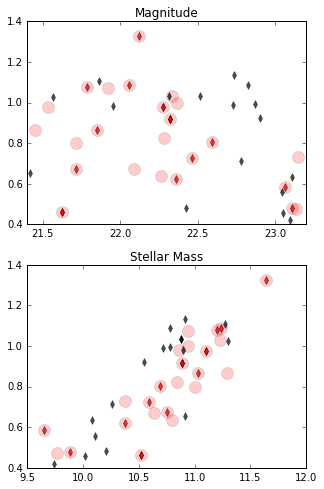

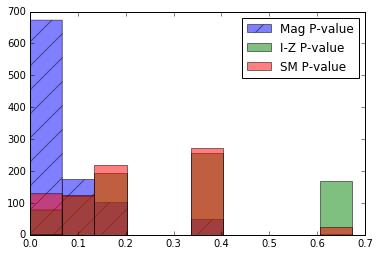

In [102]:
#Do MC resampling, since I only need to do this for two regions at a time ('merger front' and 'merger back'+'Unassigned') Regions 4 and 10 ()
#Do KS test on resampled distributions
#There is no 2D KS test because can't define 2D CDF, except for odd peacock 1987. Should do AD or 2D chisq, but need binning for chisq
#Checked with stats department and this was the most straightforward
Zcut=23.25
Ccut=1.5
py.rcParams['figure.figsize'] = (5, 8)
#sample=[]
ks_statsZ=[]
ks_statsIZ=[]
ks_statslmass=[]
for bina,binb in zip(dic['merger back'],dic['merger front']): # 'unassigned'], ['1','4','7']
    #n=len(cat_gq.xs([ 'pz'],level=['z_group_pz']).loc[bin].IZ.dropna())
    #Make into series of length n, select random values with replacement
    #could make 
    na=len(cat_gq[(cat_gq.Z<=Zcut)&(cat_gq.IZ<=Ccut)].xs([ 'high','cz'],level=['q_group','z_group']).loc[bina].Z.dropna())
    nb=len(cat_gq[(cat_gq.Z<=Zcut)&(cat_gq.IZ<=Ccut)].xs([ 'high','cz'],level=['q_group','z_group']).loc[binb].Z.dropna())
    #resetting index will save 
    Za=cat_gq[(cat_gq.Z<=Zcut)&(cat_gq.IZ<=Ccut)].xs([ 'high','cz'],level=['q_group','z_group']).loc[bina][['Z','IZ','lmass']].dropna().reset_index() #reset to give unique index
    Zb=cat_gq[(cat_gq.Z<=Zcut)&(cat_gq.IZ<=Ccut)].xs([ 'high','cz'],level=['q_group','z_group']).loc[binb][['Z','IZ','lmass']].dropna().reset_index()
    #SMa=cat_gq[(cat_gq.Z<=Zcut)&(cat_gq.IZ<=Ccut)].xs([ 'high','cz'],level=['q_group','z_group']).loc[bina][['lmass','IZ']].dropna().reset_index()
    #SMb=cat_gq[(cat_gq.Z<=Zcut)&(cat_gq.IZ<=Ccut)].xs([ 'high','cz'],level=['q_group','z_group']).loc[binb][['lmass','IZ']].dropna().reset_index()
    #kstest(Za,Zb) We want a low P-value because this means they are not drawn from the same distribution (can reject hypothesis)
    print ks_2samp(Za.Z,Zb.Z), ': Z dist High P-value means drawn from the same distribution, Low means different'
    print ks_2samp(Za.IZ,Zb.IZ),': I-Z Dist Ks stat'
    print ks_2samp(Za.lmass,Zb.lmass),': lmass Dist Ks stat'
    print ks_2samp(Za.Z,Zb.Z), ': Z dist High P-value means drawn from the same distribution, Low means different'
    print ks_2samp(Za.IZ,Zb.IZ),': I-Z Dist Ks stat'
    print ks_2samp(Za.lmass,Zb.lmass),': lmass Dist Ks stat'
    
    #Do this 1000 times
    #df=Zb #Start with dataframe of original sample as zeroth then index i+1
    #df.index.names='mc' #
    if ( (na>=nb)|(na==nb) ):
        print 'Region ', dic['merger back'],' is bigger than ',dic['merger front'],': ',na, nb
        #n_samples must be less than array of data resampling from..this doesn't make sense if it is with replacement
        #outputs dataframe so can to for Z and IZ at the same time
        #print sklearn.utils.resample(Za,n_samples=len(Zb))
        print 'Drawing array of size merger front:',len(resample(Za,n_samples=len(Zb))),len(Zb),'drawn from array of size merger back',len(Za)
        Zamc=resample(Za,n_samples=len(Zb))
        print 'Do KS test of resampled distribution for Merger Back the size of Merger Front to see if can reproduce'
        #print resample(Za,n_samples=len(Zb)).Z
        print ks_2samp(Zamc.Z,Zb.Z), ': Z dist High P-value means drawn from the same distribution, Low means different'
        print ks_2samp(Zamc.IZ,Zb.IZ),': I-Z Dist Ks stat'
        print ks_2samp(Zamc.lmass,Zb.lmass),': lmass Dist Ks stat'

        #Example plot of single draw #print Zamc.Z.values
        #'''
        py.figure(1)
        py.subplot(211)
        py.title('Magnitude')
        py.plot(Za.Z, Za.IZ,'ro',ms=12,alpha=0.2)
        py.plot(Zamc.Z, Zamc.IZ,'rd',ms=5,alpha=0.8) #Note some of these are drawn twice to overlap, some never drawn from parent red dots
        py.plot(Zb.Z, Zb.IZ,'kd',ms=5,alpha=0.7)
        py.subplot(212)
#        py.plot(Za.IZ, Za.Z,'ro',ms=12,alpha=0.2)
#        py.plot(Zamc.IZ, Zamc.Z,'rd',ms=5,alpha=0.8) #Note some of these are drawn twice to overlap, some never drawn from parent red dots
#        py.plot(Zb.IZ, Zb.Z,'kd',ms=5,alpha=0.7)
        py.title('Stellar Mass')
        py.plot(Za.lmass, Za.IZ,'ro',ms=12,alpha=0.2)
        py.plot(Zamc.lmass, Zamc.IZ,'rd',ms=5,alpha=0.8) #Note some of these are drawn twice to overlap, some never drawn from parent red dots
        py.plot(Zb.lmass, Zb.IZ,'kd',ms=5,alpha=0.7)
        #'''
        for i in range(0,1000):
                Zamc=resample(Za,n_samples=len(Zb))
                ks_statsZ.append(ks_2samp(Zamc.Z,Zb.Z)[1])
                ks_statsIZ.append(ks_2samp(Zamc.IZ,Zb.IZ)[1])
                ks_statslmass.append(ks_2samp(Zamc.lmass,Zb.lmass)[1])
                #ks_stats_t.append(ks_2samp(Zb.IZ,Zb.IZ)[1])
        py.rcParams['figure.figsize'] = (6, 4)
        py.figure(2)
        n,binss,patches=py.hist(ks_statsZ,hatch='/',alpha=0.5,label='Mag P-value')
        #py.hist(ks_statsIZ,bins=binss,alpha=0.5,label='Color P-value')
        py.hist(ks_statsIZ,bins=binss,alpha=0.5,label='I-Z P-value')
        py.hist(ks_statslmass,bins=binss,alpha=0.5,label='SM P-value')
        py.legend()
#    else: print 'SWAP SIZES manually cause I dont want to paste this and make it super long'


1.253 stdev/sqrt(N) uncertainty on the median of Z mag merger back (red), front (blue):
  [0.12917896207402116, 0.16430580776895826]
I-Z color merger back (red), front (blue): 
[0.057266507521358118, 0.076927294971369062]
Medians, Z (red,blue), I-Z (red,blue) [22.268499999999996, 22.734] [0.8145, 0.982]
STELLAR MASS: Medians, Z (red,blue), I-Z (red,blue) [10.85, 10.78] [0.8145, 0.982]
0.494718606887 19.790158853 0.345403431477 0.4655 0.1675 0.209006226484 0.0959023544826
x projection of d / 1*sigx (x1,x2 in quad) /  2.22720637481
y projection of d / 1*sigy (y1,y2 in quad) /  1.74656817243


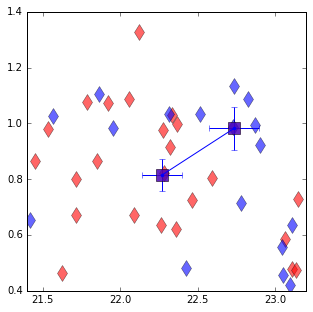

In [103]:
py.close
py.rcParams['figure.figsize'] = (5, 5)
print '1.253 stdev/sqrt(N) uncertainty on the median of Z mag merger back (red), front (blue):\n ',[1.253*Za.Z.std()/np.sqrt(len(Za.Z)),1.253*Zb.Z.std()/np.sqrt(len(Zb.Z))]
print 'I-Z color merger back (red), front (blue): \n'  ,[1.253*Za.IZ.std()/np.sqrt(len(Za.Z)),1.253*Zb.IZ.std()/np.sqrt(len(Zb.Z))]
print 'Medians, Z (red,blue), I-Z (red,blue)',[Za.Z.median(),Zb.Z.median()], [Za.IZ.median(),Zb.IZ.median()]
print 'STELLAR MASS: Medians, Z (red,blue), I-Z (red,blue)',[Za.lmass.median(),Zb.lmass.median()], [Za.IZ.median(),Zb.IZ.median()]
py.plot(Za.Z, Za.IZ,'rd',ms=12,alpha=0.6)
py.plot(Zb.Z, Zb.IZ,'bd',ms=12,alpha=0.6)
Zb[['Z','IZ']].to_csv('Red_MF_CMD.tab',sep='\t',index=False)
Za[['Z','IZ']].to_csv('Blue_MB_CMD.tab',sep='\t',index=False)
py.plot([Za.Z.median(),Zb.Z.median()], [Za.IZ.median(),Zb.IZ.median()],'rs',ms=12,alpha=0.6) #should I also do median? Median is better if there are lot of outliers
py.plot([Za.Z.median(),Zb.Z.median()], [Za.IZ.median(),Zb.IZ.median()],'bs',ms=12,alpha=0.6) #should I also do median? Median is better if there are lot of outliers
py.errorbar([Za.Z.median(),Zb.Z.median()], [Za.IZ.median(),Zb.IZ.median()],xerr=[1.253*Za.Z.std()/np.sqrt(len(Za.Z)),1.253*Zb.Z.std()/np.sqrt(len(Zb.Z))],yerr=[1.253*Za.IZ.std()/np.sqrt(len(Za.Z)),1.253*Zb.IZ.std()/np.sqrt(len(Zb.Z))],marker='.'  )
#Calculate the projection of the sum of x and y errors onto the line between the points using dot product
d=np.sqrt(  (Za.Z.median()-Zb.Z.median())**2 + (Za.IZ.median()-Zb.IZ.median())**2)
dx, dy=abs(Za.Z.median()-Zb.Z.median()) ,abs(Za.IZ.median()-Zb.IZ.median())
theta=math.degrees(math.atan(dy/dx))
sigx=np.sqrt( (1.253*Za.Z.std()/np.sqrt(len(Za.Z)))**2 + (1.253*Zb.Z.std()/np.sqrt(len(Zb.Z)))**2 )
sigy=np.sqrt( (1.253*Za.IZ.std()/np.sqrt(len(Za.Z)))**2 + (1.253*Zb.IZ.std()/np.sqrt(len(Zb.Z)))**2 )
print d,theta,math.atan(dy/dx),dx,dy,sigx,sigy
print 'x projection of d / 1*sigx (x1,x2 in quad) / ',dx/sigx
print 'y projection of d / 1*sigy (y1,y2 in quad) / ',dy/sigy

#print 'projection of sigx1 and sigx2 along d: sigx*d*cos(theta)',sigx*d*cos(math.radians(theta))
#print 'projection of sigy1 and sigy2 along d: sigy*d*sin(theta)',sigy*d*sin(math.radians(theta))
#print 'sum: ',sigx*d*sin(math.radians(theta))+sigy*d*cos(math.radians(theta))
#py.plot([Za.Z.median(),Za.Z.median()+sigx*d*sin(math.radians(theta))], [Za.IZ.median(),Za.IZ.median()+sigy*d*cos(math.radians(theta))],'r-') #should I also do median? Median is better if there are lot of outliers


1.253 stdev/sqrt(N) uncertainty on the median of Z mag merger back (red), front (blue):
  [0.12917896207402116, 0.16430580776895826]
I-Z color merger back (red), front (blue): 
[0.057266507521358118, 0.076927294971369062]
Medians, Z (red,blue), I-Z (red,blue) [22.268499999999996, 22.734] [0.8145, 0.982]
STELLAR MASS: Medians, Z (red,blue), I-Z (red,blue) [10.85, 10.78] [0.8145, 0.982]
0.181538563396 67.319440393 1.17494588546 0.07 0.1675 0.18590476556 0.0959023544826
x projection of d / 1*sigx (x1,x2 in quad) /  0.376536877842
y projection of d / 1*sigy (y1,y2 in quad) /  1.74656817243


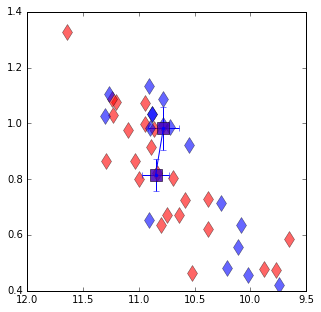

In [104]:
#Also on STELLAR MASS (less scatter, breaks degeneracy with bright blue galaxies bring bright because they are very active or have lots of stars
py.close
py.rcParams['figure.figsize'] = (5, 5)

#print [1./np.sqrt(len(Za.Z)),1./np.sqrt(len(Zb.Z))] #This is for error on the mean, which tells us how well the mean of this sample estimates the actual mean of the larger pop
#print [1./np.sqrt(len(Za.Z))/2 + 1./np.sqrt(len(Zb.Z)/2)]
#print 'distance between means is: ',np.sqrt(  (Za.Z.mean()-Zb.Z.mean())**2 + (Za.IZ.mean()-Zb.IZ.mean())**2)
#print 'distance between medians is: ',np.sqrt(  (Za.Z.median()-Zb.Z.median())**2 + (Za.IZ.median()-Zb.IZ.median())**2)
#d=np.sqrt(  (Za.Z.median()-Zb.Z.median())**2 + (Za.IZ.median()-Zb.IZ.median())**2)
#theta=
#x,y=d*np.sin(theta*np.pi/180) , d*np.cos(theta*np.pi/180)
#print 'standard dev of Z mag merger back (red), front (blue):',[Za.Z.std(),Zb.Z.std()]
#print 'standard dev of I-Z color merger back (red), front (blue):',[Za.IZ.std(),Zb.IZ.std()]
print '1.253 stdev/sqrt(N) uncertainty on the median of Z mag merger back (red), front (blue):\n ',[1.253*Za.Z.std()/np.sqrt(len(Za.Z)),1.253*Zb.Z.std()/np.sqrt(len(Zb.Z))]
print 'I-Z color merger back (red), front (blue): \n'  ,[1.253*Za.IZ.std()/np.sqrt(len(Za.Z)),1.253*Zb.IZ.std()/np.sqrt(len(Zb.Z))]
print 'Medians, Z (red,blue), I-Z (red,blue)',[Za.Z.median(),Zb.Z.median()], [Za.IZ.median(),Zb.IZ.median()]
print 'STELLAR MASS: Medians, Z (red,blue), I-Z (red,blue)',[Za.lmass.median(),Zb.lmass.median()], [Za.IZ.median(),Zb.IZ.median()]

#py.plot(Za.Z, Za.IZ,'rd',ms=12,alpha=0.6)
#        py.plot(Zamc.IZ, Zamc.Z,'rd',ms=5,alpha=0.8) #Note some of these are drawn twice to overlap, some never drawn from parent red dots
#py.plot(Zb.Z, Zb.IZ,'bd',ms=12,alpha=0.6)

py.plot(Za.lmass, Za.IZ,'rd',ms=12,alpha=0.6)
#        py.plot(Zamc.IZ, Zamc.Z,'rd',ms=5,alpha=0.8) #Note some of these are drawn twice to overlap, some never drawn from parent red dots
py.plot(Zb.lmass, Zb.IZ,'bd',ms=12,alpha=0.6)


#py.plot([Za.Z.mean(),Zb.Z.mean()], [Za.IZ.mean(),Zb.IZ.mean()],'rs',ms=12,alpha=0.6)
#py.plot([Zb.Z.mean(),Zb.Z.mean()], [Zb.IZ.mean(),Zb.IZ.mean()],'bs',ms=12,alpha=0.6)


py.plot([Za.lmass.median(),Zb.lmass.median()], [Za.IZ.median(),Zb.IZ.median()],'rs',ms=12,alpha=0.6) #should I also do median? Median is better if there are lot of outliers
py.plot([Za.lmass.median(),Zb.lmass.median()], [Za.IZ.median(),Zb.IZ.median()],'bs',ms=12,alpha=0.6) #should I also do median? Median is better if there are lot of outliers


#py.plot([Za.Z.median(),Zb.Z.median()], [Za.IZ.median(),Zb.IZ.median()],'rs',ms=12,alpha=0.6) #should I also do median? Median is better if there are lot of outliers
#py.plot([Za.Z.median(),Zb.Z.median()], [Za.IZ.median(),Zb.IZ.median()],'bs',ms=12,alpha=0.6) #should I also do median? Median is better if there are lot of outliers


#py.plot([Zb.Z.mean(),Zb.Z.mean()], [Zb.IZ.mean(),Zb.IZ.mean()],'bs',ms=12,alpha=0.6)
#Relate uncertainty on the mean to median with 1.253 from Hathi 2016

py.errorbar([Za.lmass.median(),Zb.lmass.median()], [Za.IZ.median(),Zb.IZ.median()],xerr=[1.253*Za.lmass.std()/np.sqrt(len(Za.lmass)),1.253*Zb.lmass.std()/np.sqrt(len(Zb.lmass))],yerr=[1.253*Za.IZ.std()/np.sqrt(len(Za.lmass)),1.253*Zb.IZ.std()/np.sqrt(len(Zb.lmass))],marker='.'  )
py.gca().invert_xaxis()

#py.errorbar([Za.Z.mean(),Zb.Z.mean()], [Za.IZ.mean(),Zb.IZ.mean()],xerr=[Za.Z.std(),Zb.Z.std()],yerr=[Za.IZ.std(),Zb.IZ.std()],marker='.'  )
py.savefig('2DmedianLmass.png')
#Calculate the projection of the sum of x and y errors onto the line between the points using dot product
d=np.sqrt(  (Za.lmass.median()-Zb.lmass.median())**2 + (Za.IZ.median()-Zb.IZ.median())**2)
dx, dy=abs(Za.lmass.median()-Zb.lmass.median()) ,abs(Za.IZ.median()-Zb.IZ.median())
theta=math.degrees(math.atan(dy/dx))
sigx=np.sqrt( (1.253*Za.lmass.std()/np.sqrt(len(Za.lmass)))**2 + (1.253*Zb.lmass.std()/np.sqrt(len(Zb.lmass)))**2 )
sigy=np.sqrt( (1.253*Za.IZ.std()/np.sqrt(len(Za.lmass)))**2 + (1.253*Zb.IZ.std()/np.sqrt(len(Zb.lmass)))**2 )
print d,theta,math.atan(dy/dx),dx,dy,sigx,sigy
print 'x projection of d / 1*sigx (x1,x2 in quad) / ',dx/sigx
print 'y projection of d / 1*sigy (y1,y2 in quad) / ',dy/sigy

#print 'projection of sigx1 and sigx2 along d: sigx*d*cos(theta)',sigx*d*cos(math.radians(theta))
#print 'projection of sigy1 and sigy2 along d: sigy*d*sin(theta)',sigy*d*sin(math.radians(theta))
#print 'sum: ',sigx*d*sin(math.radians(theta))+sigy*d*cos(math.radians(theta))
#py.plot([Za.Z.median(),Za.Z.median()+sigx*d*sin(math.radians(theta))], [Za.IZ.median(),Za.IZ.median()+sigy*d*cos(math.radians(theta))],'r-') #should I also do median? Median is better if there are lot of outliers


Is this difference real? Do our data represent the underlying population? We look for sampling and selection bias using an inferior data set. We can then check this independently by using photometric redshifts, varying as many things as possible to see if the difference in the distributions is real.
* p(z) Integrate the probability distribution within the photometric redshift range. Set a theoretical threshhold based on purity and completeness (similar to Type I, II errors, or false negatives and false positives)
* Using 1-2 sigma ranges for photometric redshifts (photometric redshifts using SED fitting) 

We did this for all cases plus a KS test and were able to rule out these biases as being responsible for the difference in the two distributions. Below is an example of how we came up with the threehold for the probability density integral. These are discussed in glorious gory detail in Nick Rumbaugh and Brian Lemaux's amazing ORELSE collaboration papers.

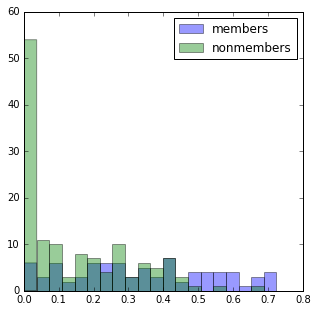

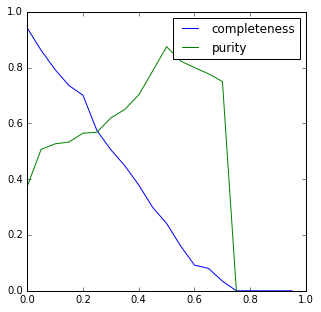

In [105]:
#Nick's probability stuff: purity vs completeness
#Plot spec members to see where probability falls off 
cat_gq.set_index(['slice_i2','slice','q_group','z_group','z_group_pz'],inplace=True,drop=False)
cat_gq=cat_gq.sortlevel() #to select with loc slice needs to be only or outer index...
Zcut,Ccut= 23.25, 1.5
Pcutmax = 1.0
Pcutmin = 0.0002
for bina,binb in zip(dic['merger back'],dic['merger front']): # 'unassigned'], ['1','4','7']
    #na=len(cat_gq[(cat_gq.Z<=Zcut)&(cat_gq.IZ<=Ccut)&(cat_gq.pzcdf<Pcut)].xs([ 'high','cz'],level=['q_group','z_group']).loc[bina].Z.dropna())
    #nb=len(cat_gq[(cat_gq.Z<=Zcut)&(cat_gq.IZ<=Ccut)&(cat_gq.pzcdf<Pcut)].xs([ 'high','cz'],level=['q_group','z_group']).loc[binb].Z.dropna())
    #resetting index will save 
    Zmem=cat_gq[(cat_gq.Z<=Zcut)&(cat_gq.IZ<=Ccut)&(cat_gq.pzcdf<=Pcutmax)&(cat_gq.pzcdf>=Pcutmin)].xs([ 'high','cz'],level=['q_group','z_group'])[['Z','IZ','lmass','pzcdf']].dropna().reset_index() #reset to give unique index
    Znm=cat_gq[(cat_gq.Z<=Zcut)&(cat_gq.IZ<=Ccut)&(cat_gq.pzcdf<=Pcutmax)&(cat_gq.pzcdf>=Pcutmin)].xs([ 'high','nz'],level=['q_group','z_group'])[['Z','IZ','lmass','pzcdf']].dropna().reset_index() #reset to give unique index
    #Zamem=cat_gq[(cat_gq.Z<=Zcut)&(cat_gq.IZ<=Ccut)&(cat_gq.pzcdf<=Pcutmax)&(cat_gq.pzcdf>=Pcutmin)].xs([ 'high','cz'],level=['q_group','z_group']).loc[bina][['Z','IZ','lmass','pzcdf']].dropna().reset_index() #reset to give unique index
    #Zbmem=cat_gq[(cat_gq.Z<=Zcut)&(cat_gq.IZ<=Ccut)&(cat_gq.pzcdf<=Pcutmax)&(cat_gq.pzcdf>=Pcutmin)].xs([ 'high','cz'],level=['q_group','z_group']).loc[binb][['Z','IZ','lmass','pzcdf']].dropna().reset_index()
    #Zanm=cat_gq[(cat_gq.Z<=Zcut)&(cat_gq.IZ<=Ccut)&(cat_gq.pzcdf<=Pcutmax)&(cat_gq.pzcdf>=Pcutmin)].xs([ 'high','nz'],level=['q_group','z_group']).loc[bina][['Z','IZ','lmass','pzcdf']].dropna().reset_index() #reset to give unique index
    #Zbnm=cat_gq[(cat_gq.Z<=Zcut)&(cat_gq.IZ<=Ccut)&(cat_gq.pzcdf<=Pcutmax)&(cat_gq.pzcdf>=Pcutmin)].xs([ 'high','nz'],level=['q_group','z_group']).loc[binb][['Z','IZ','lmass','pzcdf']].dropna().reset_index()
    n,bins,patches=py.hist(Zmem.pzcdf,bins=20,alpha=0.4,label='members')
    py.hist(Znm.pzcdf,bins=bins,alpha=0.4,label='nonmembers')
    py.legend()
    #CMD to see how many bright blue galaxies are added if increase
    #Calculate max product for different P threshholds
    completenesses=[]
    purities=[]

    for P in arange(Pcutmin,Pcutmax,0.05):
        Zmem=cat_gq[(cat_gq.Z<=Zcut)&(cat_gq.IZ<=Ccut)&(cat_gq.pzcdf>=P)].xs([ 'high','cz'],level=['q_group','z_group'])[['Z','IZ','lmass','pzcdf']].dropna().reset_index() #reset to give unique index
        Znm=cat_gq[(cat_gq.Z<=Zcut)&(cat_gq.IZ<=Ccut)&(cat_gq.pzcdf>=P)].xs([ 'high','nz'],level=['q_group','z_group'])[['Z','IZ','lmass','pzcdf']].dropna().reset_index() #reset to give unique index

#        Zmem=cat_gq[(cat_gq.Z<=Zcut)&(cat_gq.IZ<=Ccut)&(cat_gq.pzcdf<=Pcutmax)&(cat_gq.pzcdf>=Pcutmin)].xs([ 'high','cz'],level=['q_group','z_group'])[['Z','IZ','lmass','pzcdf']].dropna().reset_index() #reset to give unique index
#        Znm=cat_gq[(cat_gq.Z<=Zcut)&(cat_gq.IZ<=Ccut)&(cat_gq.pzcdf<=Pcutmax)&(cat_gq.pzcdf>=Pcutmin)].xs([ 'high','nz'],level=['q_group','z_group'])[['Z','IZ','lmass','pzcdf']].dropna().reset_index() #reset to give unique index
        Zmemall=cat_gq[(cat_gq.Z<=Zcut)&(cat_gq.IZ<=Ccut)].xs([ 'high','cz'],level=['q_group','z_group'])[['Z','IZ','lmass','pzcdf']].dropna().reset_index() #reset to give unique index
        completeness=Zmem.Z.count()*1.0/Zmemall.Z.count()
        purity=Zmem.Z.count()*1.0/(Znm.Z.count()+Zmem.Z.count())*1.0
        completenesses.append(completeness)
        purities.append(purity)
py.figure()
    #print completenesses, purities #,Zmem.Z.count()*1.0/Zmemall.Z.count()
py.plot(arange(Pcutmin,Pcutmax,0.05),completenesses,label='completeness') #decreases as increase threshold
py.plot(arange(Pcutmin,Pcutmax,0.05),purities,label='purity') #increases as increase threshold
py.legend()
#percentage where compromise between completeness and purity is 0.2255 (~0.23) (kind of depends on steps)
#Increasing p(z) threshold means objects must have a larger portion of the p(z) within the LSS redshift range to be considered within the LSS
#As threshold increases (less inclusive), purity increases bc each object is more certainly in LSS
#As threshold increases (less inclusive), completeness decreases bc we are excluding objects that may be members because they have a lower confidence

These are still the early stages of analysis. Next is the data pipline for making composites and calculating star formation rate estimates...Then we think of several more, independent ways to test this given the interesting results. More data at different wavelengths, wider range of effects. Infrared data solves the dust issue, so we know there is not a bright starbursting population we have missed in the merger front region. The Voronoi Tesselation is a similar way of mapping specific star formation rate, so SFR per unit mass...